In [86]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

def generate_points_in_sphere(n_points, radius=1000):
    points = []
    while len(points) < n_points:
        # Generate random points in the cube [-radius, radius] for x, y, z
        x = np.random.uniform(-radius, radius, n_points)
        y = np.random.uniform(-radius, radius, n_points)
        z = np.random.uniform(-radius, radius, n_points)

        # Compute distance from the origin for each point
        distances = np.sqrt(x**2 + y**2 + z**2)

        # Keep only the points within the sphere of the given radius
        inside_sphere = distances <= radius
        valid_points = np.vstack((x[inside_sphere], y[inside_sphere], z[inside_sphere])).T

        # Add valid points to the result list
        points.extend(valid_points)

        # Adjust the number of points to generate again, only if needed
        n_points -= len(valid_points)

    # Convert the list to a numpy array and return the result
    return np.array(points)

def distances_from_origin(points):
    if len(points) == 0:
        return np.array([])  # Return an empty array if no points
    return np.linalg.norm(points, axis=1)

def bucket_sort(distances, points, num_buckets=10, threshold=10):
    if len(points) <= threshold:
        return sorted(zip(distances, points))

    min_distance, max_distance = min(distances), max(distances)
    bucket_boundaries = np.linspace(min_distance, max_distance, num_buckets + 1)

    buckets = [[] for _ in range(num_buckets)]
    for dist, point in zip(distances, points):
        for i in range(num_buckets):
            if bucket_boundaries[i] <= dist < bucket_boundaries[i + 1]:
                buckets[i].append((dist, point))
                break

    sorted_points = []
    for bucket in buckets:
        if bucket:  # Only process non-empty buckets
            bucket_distances, bucket_points = zip(*bucket)  # Safely unpack
            sorted_points.extend(bucket_sort(bucket_distances, bucket_points, num_buckets=num_buckets, threshold=threshold))

    return sorted_points



def plot_points(points):
    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Unpack the points (x, y, z)
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]

    # Plot the points
    scatter = ax.scatter(x, y, z, c=np.linalg.norm(points, axis=1), cmap='viridis')

    # Add color bar for distance from the origin
    colorbar = plt.colorbar(scatter, ax=ax)
    colorbar.set_label('Distance from Origin')

    # Set plot labels and title
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_title('3D Points Inside Sphere')

    plt.show()
    

# Example usage
if __name__ == "__main__":
    n_points = 10000  # Number of points to generate
    radius = 1000  # Radius of the sphere
    points = generate_points_in_sphere(n_points, radius)
    distances = distances_from_origin(points)  # Calculate distances from the origin
    
    sorted_points = bucket_sort(distances, points)
    # Output the first few points
    print(sorted_points[:5])  # Print the first 5 points (x, y, z)


[(np.float64(36.900651132066216), array([ 6.96994704, 18.44001187, 31.19365087])), (np.float64(44.99494199593957), array([ 39.90083695,   8.11182639, -19.14853228])), (np.float64(72.10127608216044), array([ 10.35584216,  39.66764972, -59.31128148])), (np.float64(81.56151579211269), array([-80.40314097,   4.68504998, -12.87113388])), (np.float64(82.22314378140803), array([-60.64583529,  50.19778745, -23.72572802]))]


In [87]:
def dual_pivot_quick_sort(distances, points):
    """Dual pivot quick sort to sort points based on their distance from the origin."""
    if len(points) <= 1:
        return points

    # Selecting the first and last pivots
    pivot1_distance = distances[0]
    pivot2_distance = distances[-1]

    # Ensure pivot1 < pivot2
    if pivot1_distance > pivot2_distance:
        pivot1_distance, pivot2_distance = pivot2_distance, pivot1_distance

    less = []
    between = []
    greater = []

    # Partitioning the points
    for i in range(len(points)):
        if distances[i] < pivot1_distance:
            less.append(points[i])
        elif pivot1_distance <= distances[i] <= pivot2_distance:
            between.append(points[i])
        else:
            greater.append(points[i])

    # Convert lists to numpy arrays with consistent dimensions (Nx3)
    less = np.array(less) if less else np.empty((0, 3))
    between = np.array(between) if between else np.empty((0, 3))
    greater = np.array(greater) if greater else np.empty((0, 3))

    # Recursively sort the non-empty partitions
    sorted_less = dual_pivot_quick_sort(distances_from_origin(less), less) if len(less) > 0 else np.empty((0, 3))
    sorted_between = between  # Already in the correct place
    sorted_greater = dual_pivot_quick_sort(distances_from_origin(greater), greater) if len(greater) > 0 else np.empty((0, 3))

    # Concatenate results (ensure all arrays have the same dimensions)
    return np.concatenate([sorted_less, sorted_between, sorted_greater])


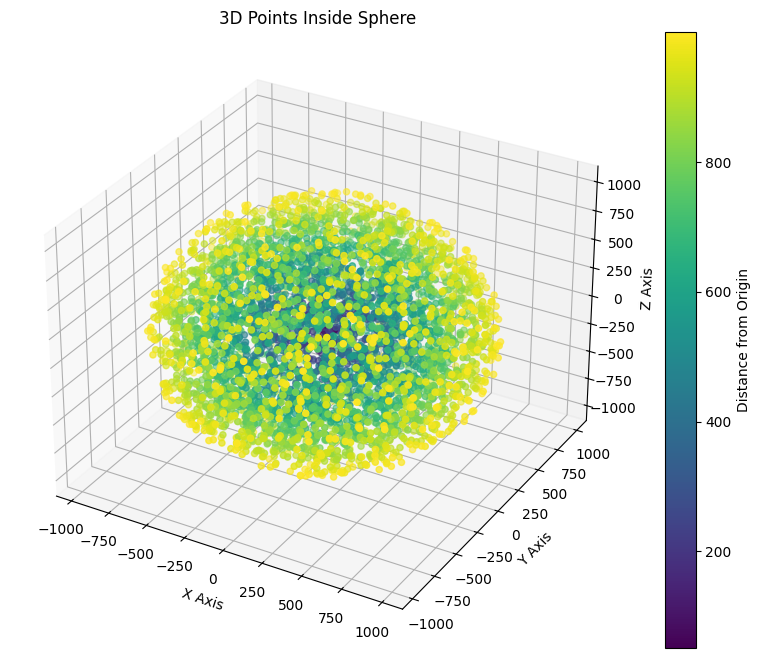

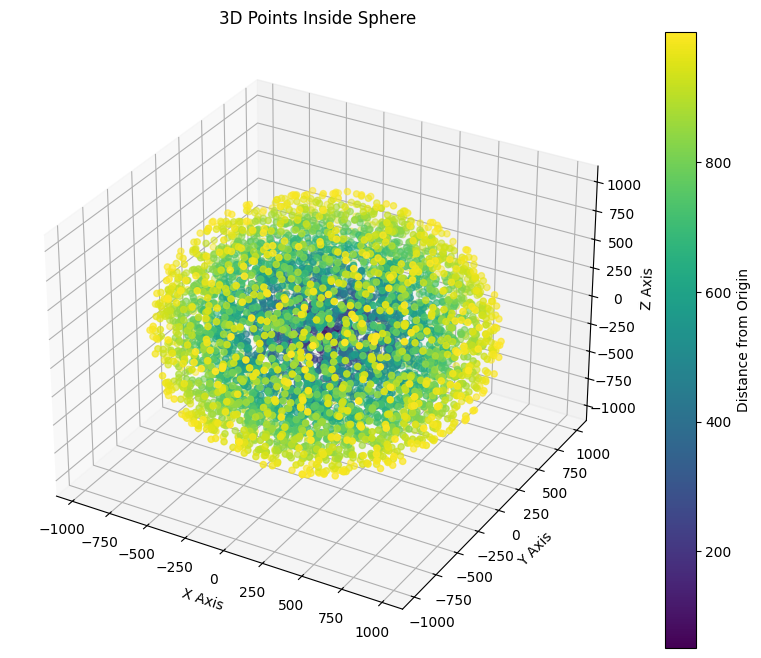

Quick Sort:0.011619
Bucket Sort:0.031162


In [89]:
if __name__ == "__main__":
    n_points = 10000  # Number of points to generate
    radius = 1000  # Radius of the sphere
    points = generate_points_in_sphere(n_points, radius)
    distances = distances_from_origin(points)  # Calculate distances from the origin
    start_time =time.time()
    sorted_points = bucket_sort(distances, points)
    bucket_sort_time = time.time() - start_time
    
    # Convert sorted points back to an array (from list of tuples)
    sorted_points_array = np.array([point for dist, point in sorted_points])
    # Plot the sorted points
    plot_points(sorted_points_array)
    start_time = time.time()
    quick_sorted_points = dual_pivot_quick_sort(distances, points)
    quick_Sort_endtime = time.time() - start_time

    quick_sorted_points_array = np.array(quick_sorted_points)
    plot_points(quick_sorted_points_array)

    print(f"Quick Sort:{quick_Sort_endtime:.6f}")
    print(f"Bucket Sort:{bucket_sort_time:.6f}")